In [1]:
import os
import pprint
import tempfile

from typing import Dict, Text

import numpy as np
import tensorflow as tf
import tensorflow_recommenders as tfrs
from dataloader import create_mvp_dataset

2025-05-04 13:08:03.577327: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-04 13:08:03.607462: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-04 13:08:03.607488: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-04 13:08:03.607518: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-04 13:08:03.613832: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-04 13:08:03.614331: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

71282
{'Title': <tf.Tensor: shape=(), dtype=string, numpy=b'Toy Story'>, 'Genre': <tf.Tensor: shape=(), dtype=string, numpy=b'Animation'>, 'Year': <tf.Tensor: shape=(), dtype=int64, numpy=1995>, 'Runtime': <tf.Tensor: shape=(), dtype=float64, numpy=81.0>, 'Popularity': <tf.Tensor: shape=(), dtype=float64, numpy=21.946943>, 'Language': <tf.Tensor: shape=(), dtype=string, numpy=b'en'>, 'Description': <tf.Tensor: shape=(), dtype=string, numpy=b"Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences.">}


2025-05-04 13:08:06.741571: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-05-04 13:08:06.762959: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [2]:
dataset = create_mvp_dataset()
movies = dataset.batch(32)

unique_titles = set()
unique_genres = set()

for batch in movies:
    # print(batch)
    titles = batch['Title'].numpy()  # tensor of strings
    genres = batch['Genre'].numpy()
    unique_titles.update(titles)
    unique_genres.update(genres)

unique_titles = np.array(list(unique_titles))
unique_genres = np.array(list(unique_genres))
unique_langs = np.array(['en', 'hi', 'fr'])



71282


In [3]:
movies = dataset.map(lambda x: x["Title"])
descriptions = dataset.map(lambda x: x["Description"])
language = dataset.map(lambda x: x["Language"])
years = np.concatenate(list(dataset.map(lambda x: x["Year"]).batch(100)))
runtimes = np.concatenate(list(dataset.map(lambda x: x["Runtime"]).batch(100)))
popularity = np.concatenate(list(dataset.map(lambda x: x["Popularity"]).batch(100)))

In [4]:
max_year = years.max()
min_year = years.min()

year_buckets = np.arange(
    min_year, max_year, 4
)


In [5]:
print(year_buckets)

[1878 1882 1886 1890 1894 1898 1902 1906 1910 1914 1918 1922 1926 1930
 1934 1938 1942 1946 1950 1954 1958 1962 1966 1970 1974 1978 1982 1986
 1990 1994 1998 2002 2006 2010 2014 2018]


In [6]:
class SafeAveragePooling(tf.keras.layers.Layer):
    def call(self, inputs, mask=None):
        if mask is not None:
            mask = tf.cast(mask[:, :, tf.newaxis], tf.float32)
            summed = tf.reduce_sum(inputs * mask, axis=1)
            count = tf.reduce_sum(mask, axis=1)
            return summed / (count + 1e-8)
        else:
            return tf.reduce_mean(inputs, axis=1)

class UserModel(tf.keras.Model):

  def __init__(self):
    super().__init__()

    max_tokens = 10000

    self.genre_embedding = tf.keras.Sequential([
        tf.keras.layers.StringLookup(
            vocabulary=unique_genres, mask_token=None),
        tf.keras.layers.Embedding(len(unique_genres) + 1, 32),
    ])
    self.lang_embedding = tf.keras.Sequential([
        tf.keras.layers.StringLookup(
            vocabulary=unique_langs, mask_token=None),
        tf.keras.layers.Embedding(len(unique_langs) + 1, 32),
    ])
    self.year_embedding = tf.keras.Sequential([
        tf.keras.layers.Discretization(year_buckets.tolist()),
        tf.keras.layers.Embedding(len(year_buckets) + 1, 32),
    ])
    self.normalized_popularity = tf.keras.layers.Normalization(
        axis=None
    )
    self.normalized_runtime = tf.keras.layers.Normalization(
        axis=None
    )
    self.desc_vectorizer = tf.keras.layers.TextVectorization(
        max_tokens=max_tokens)

    self.desc_embedding = tf.keras.Sequential([
      self.desc_vectorizer,
      tf.keras.layers.Embedding(max_tokens, 32, mask_zero=True),
    #   tf.keras.layers.GlobalAveragePooling1D(),
      SafeAveragePooling(),

    ])


    self.desc_vectorizer.adapt(descriptions)
    self.normalized_popularity.adapt(popularity)
    self.normalized_runtime.adapt(runtimes)

  def call(self, inputs):
    # Take the input dictionary, pass it through each input layer,
    # and concatenate the result.
    return tf.concat([
        self.genre_embedding(inputs["Genre"]),
        self.year_embedding(inputs["Year"]),
        self.desc_embedding(inputs["Description"]),
        self.lang_embedding(inputs["Language"]),
        tf.reshape(self.normalized_popularity(inputs["Popularity"]), (-1, 1)),
        tf.reshape(self.normalized_runtime(inputs["Runtime"]), (-1, 1)),
    ], axis=1)


In [7]:
class QueryModel(tf.keras.Model):
  """Model for encoding user queries."""

  def __init__(self, layer_sizes):
    """Model for encoding user queries.

    Args:
      layer_sizes:
        A list of integers where the i-th entry represents the number of units
        the i-th layer contains.
    """
    super().__init__()

    # We first use the user model for generating embeddings.
    self.embedding_model = UserModel()

    # Then construct the layers.
    self.dense_layers = tf.keras.Sequential([
      tf.keras.layers.Dense(layer_sizes[0])
    ])

    # Use the ReLU activation for all but the last layer.
    for layer_size in layer_sizes[:-1]:
      self.dense_layers.add(tf.keras.layers.Dense(layer_size, activation="relu"))

    # No activation for the last layer.
    for layer_size in layer_sizes[-1:]:
      self.dense_layers.add(tf.keras.layers.Dense(layer_size))

  def call(self, inputs):
    feature_embedding = self.embedding_model(inputs)
    return self.dense_layers(feature_embedding)

In [8]:
class MovieModel(tf.keras.Model):

  def __init__(self):
    super().__init__()

    max_tokens = 10_000

    self.title_embedding = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
          vocabulary=unique_titles,mask_token=None),
      tf.keras.layers.Embedding(len(unique_titles) + 1, 32)
    ])

    self.title_vectorizer = tf.keras.layers.TextVectorization(
        max_tokens=max_tokens)

    self.title_text_embedding = tf.keras.Sequential([
      self.title_vectorizer,
      tf.keras.layers.Embedding(max_tokens, 32, mask_zero=True),
      # tf.keras.layers.GlobalAveragePooling1D(),
      SafeAveragePooling(),
    ])

    self.title_vectorizer.adapt(movies)

  def call(self, titles):
    return tf.concat([
        self.title_embedding(titles),
        self.title_text_embedding(titles),
    ], axis=1)

In [9]:
class CandidateModel(tf.keras.Model):
  """Model for encoding movies."""

  def __init__(self, layer_sizes):
    """Model for encoding movies.

    Args:
      layer_sizes:
        A list of integers where the i-th entry represents the number of units
        the i-th layer contains.
    """
    super().__init__()

    self.embedding_model = MovieModel()

    # Then construct the layers.
    self.dense_layers = tf.keras.Sequential([
      tf.keras.layers.Dense(layer_sizes[0])
    ])

    # Use the ReLU activation for all but the last layer.
    for layer_size in layer_sizes[:-1]:
      self.dense_layers.add(tf.keras.layers.Dense(layer_size, activation="relu"))

    # No activation for the last layer.
    for layer_size in layer_sizes[-1:]:
      self.dense_layers.add(tf.keras.layers.Dense(layer_size))

    # embedding_dim = 32
    # self.dense_layers.build([None, embedding_dim])


  def call(self, inputs):
    feature_embedding = self.embedding_model(inputs)
    return self.dense_layers(feature_embedding)

In [10]:
class MovielensModel(tfrs.models.Model):

  def __init__(self, layer_sizes_query, layer_sizes_cand):
    super().__init__()
    self.query_model = QueryModel(layer_sizes_query)
    self.candidate_model = CandidateModel(layer_sizes_cand)
    self.task = tfrs.tasks.Retrieval(
        metrics=tfrs.metrics.FactorizedTopK(
            candidates=movies.batch(32).map(self.candidate_model),
        ),
    )

  def compute_loss(self, features, training=False):
    query_embeddings = self.query_model({
        "Genre": features["Genre"],
        "Year": features["Year"],
        "Popularity": features["Popularity"],
        "Runtime": features["Runtime"],
        "Description": features["Description"],
        "Language": features["Language"]
    })
    # tf.print(f"Query_emb ", query_embeddings)
    movie_embeddings = self.candidate_model(features["Title"])
    # tf.print("Movie_emb " , movie_embeddings)

    return self.task(
        query_embeddings, movie_embeddings, compute_metrics=not training)

In [11]:
shuffled = dataset.shuffle(72000, seed=42, reshuffle_each_iteration=False)
test = shuffled.take(1000)
cached_train = dataset.batch(256).cache()
cached_test = test.batch(128).cache()


In [27]:
# For checking model definitions
cand_model = CandidateModel([32])
quer_model = QueryModel([32])

/home/ds_students/anaconda3/envs/moodfli/lib/python3.10/site-packages/numpy/core/numeric.py:2468: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


In [12]:
num_epochs = 30

model = MovielensModel([32], [32])
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.01))

tf.debugging.enable_check_numerics()

one_layer_history = model.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=5,
    epochs=num_epochs,
    verbose=1)

/home/ds_students/anaconda3/envs/moodflix/lib/python3.10/site-packages/numpy/core/numeric.py:2468: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


INFO:tensorflow:Enabled check-numerics callback in thread MainThread
Epoch 1/30
279/279 [==============================] - 7s 19ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 1403.3923 - regularization_loss: 0.0000e+00 - total_loss: 1403.3923
Epoch 2/30
279/279 [==============================] - 5s 18ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 1339.1865 - regularization_loss: 0.0000e+00 - total_loss: 1339.1865
Epoch 3/30
279/279 [==============================] - 5s 

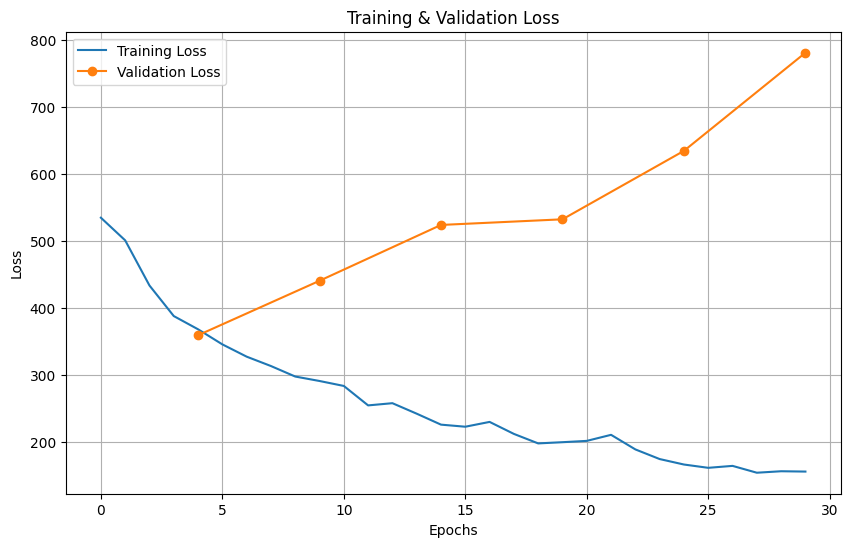

In [13]:
import matplotlib.pyplot as plt

# Get the history dictionary
history = one_layer_history.history

# Extract loss and val_loss
loss = history['loss']
val_loss = history.get('val_loss', None)  # May be None if validation_freq hasn't triggered yet

# Plot
plt.figure(figsize=(10, 6))
plt.plot(loss, label='Training Loss')
if val_loss:
    # Plot only the validation loss points that were recorded (since val is logged only every 5 epochs)
    val_epochs = list(range(4, len(loss), 5))  # because validation_freq=5
    plt.plot(val_epochs, val_loss, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


In [14]:
accuracy = one_layer_history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]
print(f"Top-100 accuracy: {accuracy:.2f}.")

Top-100 accuracy: 0.06.


In [49]:
# Create a model that takes in raw query features, and
index = tfrs.layers.factorized_top_k.BruteForce(model.query_model)
# recommends movies out of the entire movies dataset.
index.index_from_dataset(
  tf.data.Dataset.zip((movies.batch(100), movies.batch(100).map(model.candidate_model)))
)

# Get recommendations.
for row in test.batch(1).take(1):
    print(row)
    _, titles = index(row)
    titles_raw = titles.numpy().tolist()
    print(titles_raw)
    titles_str = [b.decode('utf-8') for b in titles_raw[0]]
    print(type(titles_str))
    print(f"Recommendations: {titles_str[:10]}")

{'Title': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Hanky Panky'], dtype=object)>, 'Genre': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Comedy'], dtype=object)>, 'Year': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1982])>, 'Runtime': <tf.Tensor: shape=(1,), dtype=float64, numpy=array([110.])>, 'Popularity': <tf.Tensor: shape=(1,), dtype=float64, numpy=array([8.240643])>, 'Language': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'en'], dtype=object)>, 'Description': <tf.Tensor: shape=(1,), dtype=string, numpy=
array([b'The complete innocent, Michael Jordon, is drawn into a web of secrecy and government secrets when a girl carrying a mysterious package gets into a taxi with him. When she is later murdered, Michael is the chief suspect and on the run.'],
      dtype=object)>}
[[b"Flyin' Ryan", b'Asambhav', b'Asambhav', b'Asambhav', b'The Scalphunters', b'The Scalphunters', b'The Scalphunters', b'The Parole Officer', b'The Parole Officer', b'Unstable Fables:

In [20]:
# Create a model that takes in raw query features, and
index = tfrs.layers.factorized_top_k.BruteForce(model.query_model)
# recommends movies out of the entire movies dataset.
index.index_from_dataset(
  tf.data.Dataset.zip((movies.batch(100), movies.batch(100).map(model.candidate_model)))
)

class RetrievalModel(tf.Module):
    def __init__(self, index):
        super().__init__()
        self.index = index

    @tf.function(input_signature=[
        {
            "Title": tf.TensorSpec(shape=[None], dtype=tf.string),
            "Genre": tf.TensorSpec(shape=[None], dtype=tf.string),
            "Year": tf.TensorSpec(shape=[None], dtype=tf.int64),
            "Runtime": tf.TensorSpec(shape=[None], dtype=tf.float32),  # Changed from float64
            "Popularity": tf.TensorSpec(shape=[None], dtype=tf.float32),  # Changed from float64
            "Language": tf.TensorSpec(shape=[None], dtype=tf.string),
            "Description": tf.TensorSpec(shape=[None], dtype=tf.string),
        }
    ])
    def __call__(self, inputs):
        return self.index(inputs)

# Build your BruteForce index
# e.g., index = tfrs.layers.factorized_top_k.BruteForce(...)

# Wrap it
wrapped_model = RetrievalModel(index)

# Save
tf.saved_model.save(wrapped_model, "final_input_index")


INFO:tensorflow:Assets written to: final_input_index/assets


INFO:tensorflow:Assets written to: final_input_index/assets


In [29]:
from fastapi import FastAPI, HTTPException
import uvicorn
from pydantic import BaseModel
import joblib
import numpy as np
import pandas as pd
from typing import List, Union
import nest_asyncio
nest_asyncio.apply()

In [51]:
app = FastAPI(title="Model Serving API")

# Define input schema for TensorFlow-compatible data
class PredictionInput(BaseModel):
    Title: List[str]
    Genre: List[str]
    Year: List[int]
    Runtime: List[float]
    Popularity: List[float]
    Language: List[str]
    Description: List[str]
    
    # Example configuration
    class Config:
        json_schema_extra = {
            "example": {
                "Title": ["Hanky Panky"],
                "Genre": ["Comedy"],
                "Year": [1982],
                "Runtime": [110.0],
                "Popularity": [0.5],
                "Language": ["English"],
                "Description": ["The complete innocent, Michael Jordon, is drawn into a web..."]
            }
        }

# Output schema for prediction results
class PredictionOutput(BaseModel):
    scores: List[float]
    titles: List[str]
    
    class Config:
        json_schema_extra = {
            "example": {
                "scores": [0.8, 0.7, 0.9, 0.6, 0.5],
                "titles": ["Movie 1", "Movie 2", "Movie 3", "Movie 4", "Movie 5"]
            }
        }

@app.get("/")
async def root():
    return {"message": "Model Serving API is running"}

@app.post("/predict", response_model=PredictionOutput)
async def predict(input_data: PredictionInput):
    try:
        # Convert input to appropriate format (adjust based on your model)
        sample_input = {
            "Title": tf.constant(input_data.Title),
            "Genre": tf.constant(input_data.Genre),
            "Year": tf.constant(input_data.Year, dtype=tf.int64),
            "Runtime": tf.constant(input_data.Runtime, dtype=tf.float32),
            "Popularity": tf.constant(input_data.Popularity, dtype=tf.float32),
            "Language": tf.constant(input_data.Language),
            "Description": tf.constant(input_data.Description),
        }
        
#         {'Title': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Hanky Panky'], dtype=object)>, 'Genre': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Comedy'], dtype=object)>, 'Year': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1982])>, 'Runtime': <tf.Tensor: shape=(1,), dtype=float64, numpy=array([110.])>, 'Popularity': <tf.Tensor: shape=(1,), dtype=float64, numpy=array([8.240643])>, 'Language': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'en'], dtype=object)>, 'Description': <tf.Tensor: shape=(1,), dtype=string, numpy=
# array([b'The complete innocent, Michael Jordon, is drawn into a web of secrecy and government secrets when a girl carrying a mysterious package gets into a taxi with him. When she is later murdered, Michael is the chief suspect and on the run.'],
#       dtype=object)>}
        # Make prediction
        scores, pred = index(sample_input)

        titles_raw = pred.numpy().tolist()
        fin_title = [title.decode('utf-8') for title in titles_raw[0]]
        scores_raw = [12, 23]
        
        return PredictionOutput(scores=scores_raw, titles=fin_title)
            
    except Exception as e:
        raise HTTPException(status_code=400, detail=str(e))

# Run the server (blocking)
if __name__ == "__main__":
    uvicorn.run(app, host="0.0.0.0", port=5000)

INFO:     Started server process [9572]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:5000 (Press CTRL+C to quit)


In [28]:
# In a Jupyter notebook cell
import nest_asyncio
nest_asyncio.apply()

# Run the server (blocking)
if __name__ == "__main__":
    uvicorn.run(app, host="0.0.0.0", port=5000)

INFO:     Started server process [9572]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO:     127.0.0.1:49580 - "GET / HTTP/1.1" 200 OK
INFO:     127.0.0.1:52942 - "GET / HTTP/1.1" 200 OK


INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [9572]
